In [203]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Функция для рисования матрицы ошибок

In [204]:
def plot_conf_matrix(y_test, y_pred, y_train, y_pred_train, model_name):
    classes = ['BI-аналитик,\nаналитик\nданных', 'Бизнес-\nаналитик',
       'Маркетолог-\nаналитик', 'Продуктовый\nаналитик',
       'Руководитель\nотдела\nаналитики', 'Системный\nаналитик',
       'Финансовый\nаналитик,\nинвестиционный\nаналитик']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax1, cmap = plt.cm.Blues, normalize = 'true')
    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, ax=ax2, cmap = plt.cm.Blues, normalize = 'true')
    ax1.xaxis.set_ticklabels(classes)
    ax1.yaxis.set_ticklabels(classes)
    ax2.xaxis.set_ticklabels(classes)
    ax2.yaxis.set_ticklabels(classes)
    ax1.tick_params(axis='x', labelsize=9, labelrotation = 60)
    ax2.tick_params(axis='x', labelsize=9, labelrotation = 60)
    _ = ax1.set_title(
        f"{model_name} (test)")
    _ = ax2.set_title(
        f"{model_name} (train)")

Функция для вывода оценок и матрицы ошибок

In [205]:
def estimation(model, X_test, X_train, y_test, y_train, model_name):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print('Accuracy Training data: {:.2%}'.format(accuracy_score(y_train, y_pred_train)))
    print('Accuracy Test data: {:.2%}'.format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred, target_names=model.classes_))
    plot_conf_matrix(y_test, y_pred, y_train, y_pred_train, model_name)

Загрузка данных

In [206]:
df_full = pd.read_json('preprocessed_text.json')
df_full['clean_descr'] = df_full['d_wo_sw'].apply(lambda x: ' '.join(x))
df = df_full[['id', 'clean_descr', 'proffesional_roles']].copy()

Отбираем категории, убираем "аналитик", "другое", "программист, разработчик", "дата-сайентист"

In [207]:
categories = ['Системный аналитик' ,'Продуктовый аналитик', 'Финансовый аналитик, инвестиционный аналитик',
 'Маркетолог-аналитик', 'Бизнес-аналитик', 'BI-аналитик, аналитик данных', 'Руководитель отдела аналитики']
df = df[df['proffesional_roles'].isin(categories)]
df = df.drop_duplicates(['clean_descr'])
df.reset_index(drop = True, inplace=True)

In [208]:
X = df['clean_descr']
y = df['proffesional_roles']

Разделение на train и test

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df['proffesional_roles'])

Количество размеченных описаний вакансий по проф. ролям

In [210]:
print('Total number of descriptions: {}'.format(len(df)))
print(40*'-')
print('Split by proffesional_roles:')
print(df["proffesional_roles"].value_counts())
print(40*'-')
nr_categories = len(df["proffesional_roles"].unique())
print("Number of proffesional_roles: {n}".format(n=nr_categories))

Total number of descriptions: 7383
----------------------------------------
Split by proffesional_roles:
Системный аналитик                              1983
Бизнес-аналитик                                 1904
Финансовый аналитик, инвестиционный аналитик    1603
BI-аналитик, аналитик данных                     784
Маркетолог-аналитик                              499
Продуктовый аналитик                             393
Руководитель отдела аналитики                    217
Name: proffesional_roles, dtype: int64
----------------------------------------
Number of proffesional_roles: 7


Векторизация текста методом TF-IDF

In [313]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,4), min_df = 5, max_features=50000)
tfidf_vect.fit(X_train, y_train)

TfidfVectorizer(max_features=50000, min_df=5, ngram_range=(1, 4))

Логистическая регрессия

In [212]:
from sklearn.linear_model import LogisticRegression

In [213]:
logreg_tfidf = Pipeline([('tfidf', tfidf_vect), 
('logreg', LogisticRegression(multi_class = 'multinomial', solver ='saga', max_iter = 100, penalty = 'l1'))])

In [214]:
logreg_tfidf.fit(X_train, y_train)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, min_df=5,
                                 ngram_range=(1, 4))),
                ('logreg',
                 LogisticRegression(multi_class='multinomial', penalty='l1',
                                    solver='saga'))])

Accuracy Training data: 78.25%
Accuracy Test data: 77.56%
                                              precision    recall  f1-score   support

                BI-аналитик, аналитик данных       0.68      0.66      0.67       235
                             Бизнес-аналитик       0.72      0.76      0.74       571
                         Маркетолог-аналитик       0.77      0.74      0.76       150
                        Продуктовый аналитик       0.80      0.52      0.63       118
               Руководитель отдела аналитики       0.48      0.17      0.25        65
                          Системный аналитик       0.82      0.87      0.85       595
Финансовый аналитик, инвестиционный аналитик       0.85      0.89      0.87       481

                                    accuracy                           0.78      2215
                                   macro avg       0.73      0.66      0.68      2215
                                weighted avg       0.77      0.78      0.77     

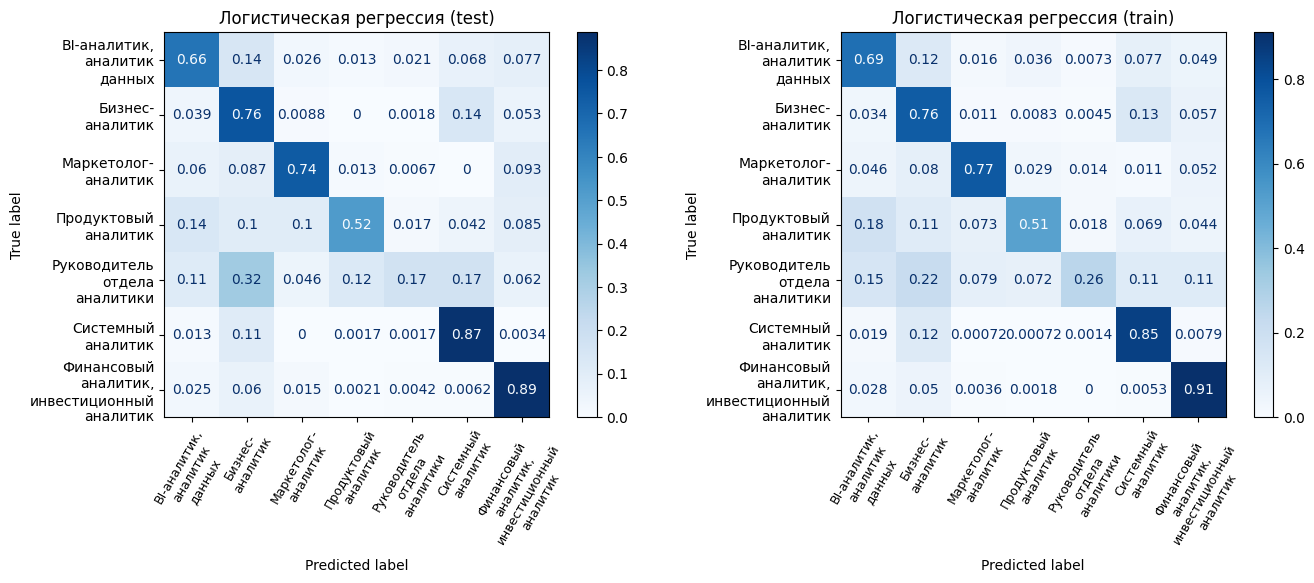

In [215]:
estimation(logreg_tfidf, X_test, X_train, y_test, y_train, 'Логистическая регрессия')

In [216]:
print('Classes of the model: ',logreg_tfidf['logreg'].classes_)
print(80*'-')
print('Shape of the coefficients of the model (categories x vocabulary size): ',logreg_tfidf['logreg'].coef_.shape)
print(80*'-')
NN = 10
# Get the 10 (here: NN, which you can adjust yourself) ids of the words with highest weights per category
top_words = np.argsort(logreg_tfidf['logreg'].coef_,axis=1)[:,-NN:]

# Get the vocabulary of the model (mapping of words to ids):
voc = logreg_tfidf['tfidf'].vocabulary_
# Get the inverse vocabulary to map the ids of the words to the words:
inv_voc = {v: k for k, v in voc.items()}

# Get for each category (=class) the top ten words
for n, w in enumerate(logreg_tfidf['logreg'].classes_):
    t = w + ': '
    for i in range(NN):
        t += inv_voc[top_words[n,i]]
        if i!=NN:
            t+=', '
    print(t)
    print(80*'-')

Classes of the model:  ['BI-аналитик, аналитик данных' 'Бизнес-аналитик' 'Маркетолог-аналитик'
 'Продуктовый аналитик' 'Руководитель отдела аналитики'
 'Системный аналитик' 'Финансовый аналитик, инвестиционный аналитик']
--------------------------------------------------------------------------------
Shape of the coefficients of the model (categories x vocabulary size):  (7, 50000)
--------------------------------------------------------------------------------
BI-аналитик, аналитик данных: and, qlik, dwh, powerbi, data, аналитика данные, sql, python, данные, bi, 
--------------------------------------------------------------------------------
Бизнес-аналитик: описание, проект, информация, бизнес системный, бизнес системный аналитика, требование, процесс, бизнес аналитик, бизнес, бизнес аналитика, 
--------------------------------------------------------------------------------
Маркетолог-аналитик: продажа, сайт, анализ, рынок, рекламный, реклама, конкурент, маркетинг, маркетинговый, м

Наивный Байес + PCA

In [217]:
from sklearn.naive_bayes import MultinomialNB

In [218]:
from sklearn.decomposition import TruncatedSVD 
pca = TruncatedSVD (n_components=2000, random_state=42)

In [219]:
from sklearn.preprocessing import MinMaxScaler

In [220]:
scaler = MinMaxScaler()

In [221]:
nb_tfidf_pca = Pipeline([('tfidf', tfidf_vect), ('pca', pca), ('scaler', scaler), ('NaiveBayes', MultinomialNB())])

In [222]:
nb_tfidf_pca.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, min_df=5,
                                 ngram_range=(1, 4))),
                ('pca', TruncatedSVD(n_components=2000, random_state=42)),
                ('scaler', MinMaxScaler()), ('NaiveBayes', MultinomialNB())])

Accuracy Training data: 57.57%
Accuracy Test data: 52.28%


c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

                                              precision    recall  f1-score   support

                BI-аналитик, аналитик данных       0.00      0.00      0.00       235
                             Бизнес-аналитик       0.37      0.62      0.46       571
                         Маркетолог-аналитик       0.00      0.00      0.00       150
                        Продуктовый аналитик       0.00      0.00      0.00       118
               Руководитель отдела аналитики       0.00      0.00      0.00        65
                          Системный аналитик       0.56      0.94      0.70       595
Финансовый аналитик, инвестиционный аналитик       0.96      0.50      0.66       481

                                    accuracy                           0.52      2215
                                   macro avg       0.27      0.30      0.26      2215
                                weighted avg       0.45      0.52      0.45      2215



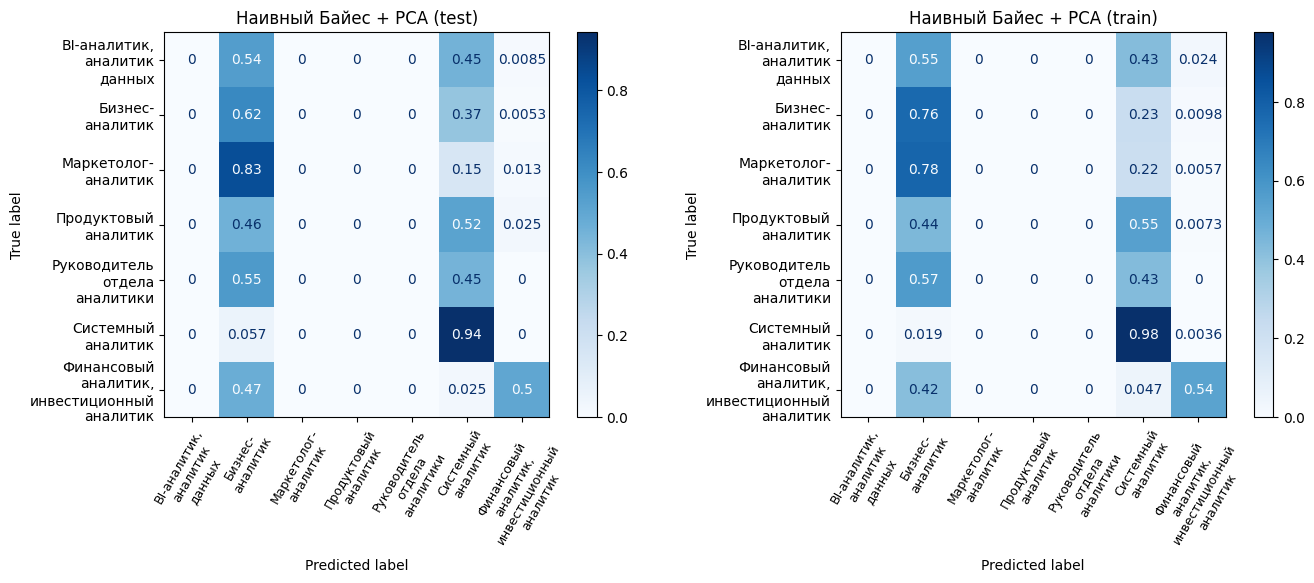

In [224]:
estimation(nb_tfidf_pca, X_test, X_train, y_test, y_train, 'Наивный Байес + PCA')

Наивный Байес

In [225]:
nb_tfidf = Pipeline([('tfidf', tfidf_vect), ('NaiveBayes', MultinomialNB())])

In [226]:
nb_tfidf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, min_df=5,
                                 ngram_range=(1, 4))),
                ('NaiveBayes', MultinomialNB())])

Accuracy Training data: 69.95%
Accuracy Test data: 63.12%
                                              precision    recall  f1-score   support

                BI-аналитик, аналитик данных       0.39      0.06      0.10       235
                             Бизнес-аналитик       0.51      0.72      0.60       571
                         Маркетолог-аналитик       1.00      0.08      0.15       150
                        Продуктовый аналитик       0.83      0.04      0.08       118
               Руководитель отдела аналитики       0.00      0.00      0.00        65
                          Системный аналитик       0.69      0.86      0.76       595
Финансовый аналитик, инвестиционный аналитик       0.73      0.93      0.82       481

                                    accuracy                           0.63      2215
                                   macro avg       0.59      0.38      0.36      2215
                                weighted avg       0.63      0.63      0.56     

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

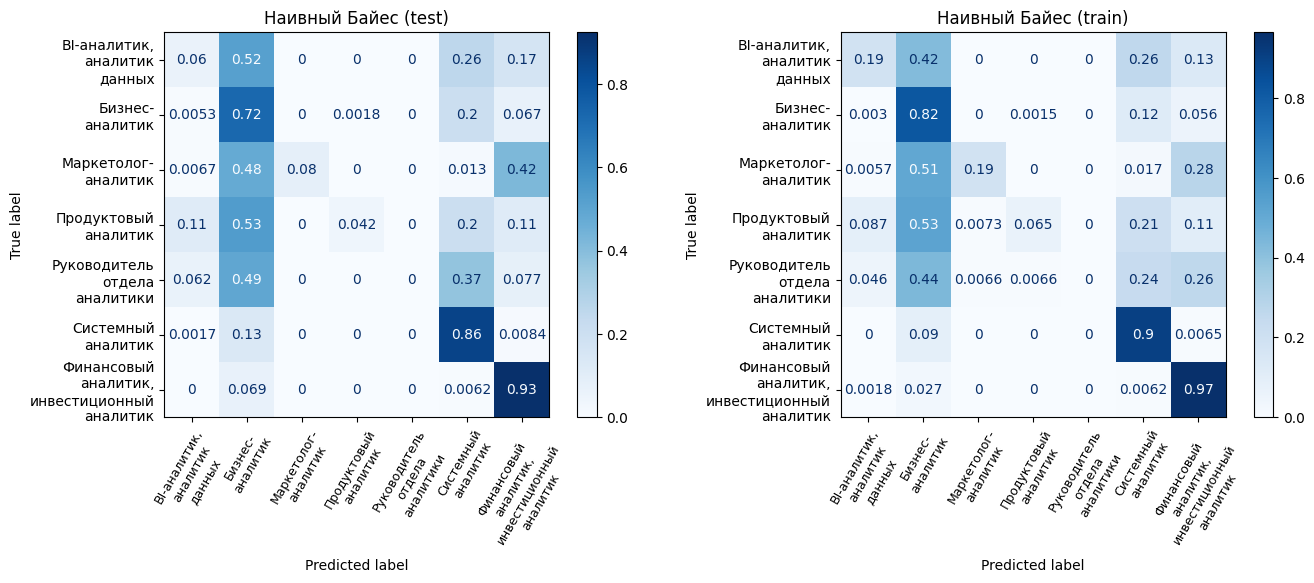

In [227]:
estimation(nb_tfidf, X_test, X_train, y_test, y_train, 'Наивный Байес')

KNN (Слишком долго)

In [228]:
from sklearn.neighbors import KNeighborsClassifier

In [229]:
knn_tfidf = Pipeline([('tfidf', tfidf_vect), ('KNN', KNeighborsClassifier())])

In [230]:
knn_tfidf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, min_df=5,
                                 ngram_range=(1, 4))),
                ('KNN', KNeighborsClassifier())])

Accuracy Training data: 76.80%
Accuracy Test data: 65.64%
                                              precision    recall  f1-score   support

                BI-аналитик, аналитик данных       0.41      0.44      0.43       235
                             Бизнес-аналитик       0.60      0.64      0.62       571
                         Маркетолог-аналитик       0.65      0.68      0.67       150
                        Продуктовый аналитик       0.52      0.40      0.45       118
               Руководитель отдела аналитики       0.50      0.08      0.13        65
                          Системный аналитик       0.72      0.74      0.73       595
Финансовый аналитик, инвестиционный аналитик       0.80      0.81      0.81       481

                                    accuracy                           0.66      2215
                                   macro avg       0.60      0.54      0.55      2215
                                weighted avg       0.65      0.66      0.65     

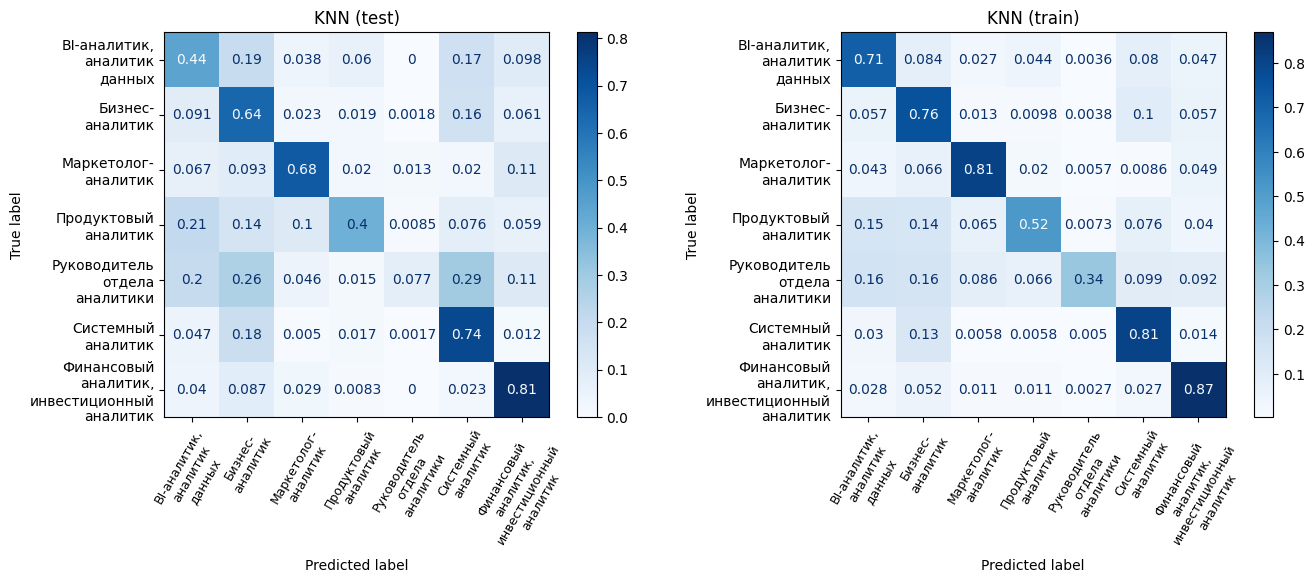

In [231]:
estimation(knn_tfidf, X_test, X_train, y_test, y_train, 'KNN')


SVM

In [232]:
from sklearn.svm import SVC

In [233]:
svm = Pipeline([('tfidf', tfidf_vect), ('svm', SVC(kernel = 'sigmoid', max_iter = 2000))])

In [234]:
svm.fit(X_train, y_train)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, min_df=5,
                                 ngram_range=(1, 4))),
                ('svm', SVC(kernel='sigmoid', max_iter=2000))])

Accuracy Training data: 90.91%
Accuracy Test data: 79.37%
                                              precision    recall  f1-score   support

                BI-аналитик, аналитик данных       0.67      0.66      0.67       235
                             Бизнес-аналитик       0.73      0.78      0.76       571
                         Маркетолог-аналитик       0.77      0.77      0.77       150
                        Продуктовый аналитик       0.78      0.58      0.66       118
               Руководитель отдела аналитики       0.75      0.18      0.30        65
                          Системный аналитик       0.85      0.87      0.86       595
Финансовый аналитик, инвестиционный аналитик       0.87      0.91      0.89       481

                                    accuracy                           0.79      2215
                                   macro avg       0.77      0.68      0.70      2215
                                weighted avg       0.79      0.79      0.79     

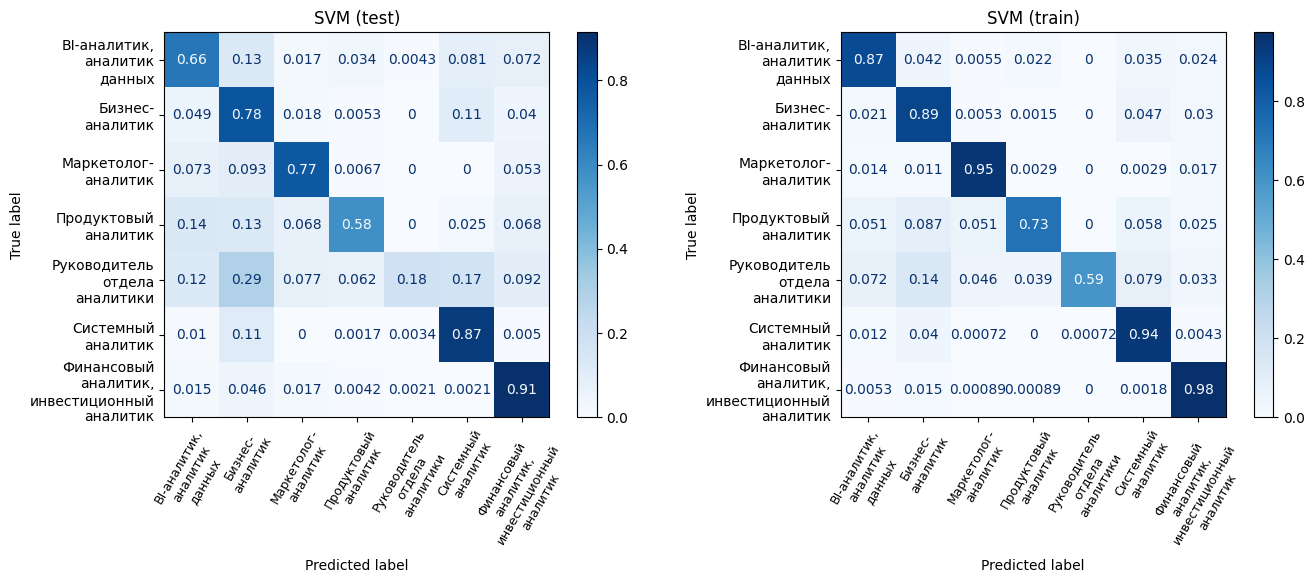

In [235]:
estimation(svm, X_test, X_train, y_test, y_train, 'SVM')

Random Forest

In [236]:
from sklearn.ensemble import RandomForestClassifier

In [320]:
randForest_tfidf = Pipeline([('tfidf', tfidf_vect), ('randForest', RandomForestClassifier(n_estimators = 70))])
randForest_tfidf.fit(X_test, y_test)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, min_df=5,
                                 ngram_range=(1, 4))),
                ('randForest', RandomForestClassifier(n_estimators=70))])

Accuracy Training data: 73.66%
Accuracy Test data: 100.00%
                                              precision    recall  f1-score   support

                BI-аналитик, аналитик данных       1.00      1.00      1.00       235
                             Бизнес-аналитик       1.00      1.00      1.00       571
                         Маркетолог-аналитик       1.00      1.00      1.00       150
                        Продуктовый аналитик       1.00      1.00      1.00       118
               Руководитель отдела аналитики       1.00      1.00      1.00        65
                          Системный аналитик       1.00      1.00      1.00       595
Финансовый аналитик, инвестиционный аналитик       1.00      1.00      1.00       481

                                    accuracy                           1.00      2215
                                   macro avg       1.00      1.00      1.00      2215
                                weighted avg       1.00      1.00      1.00    

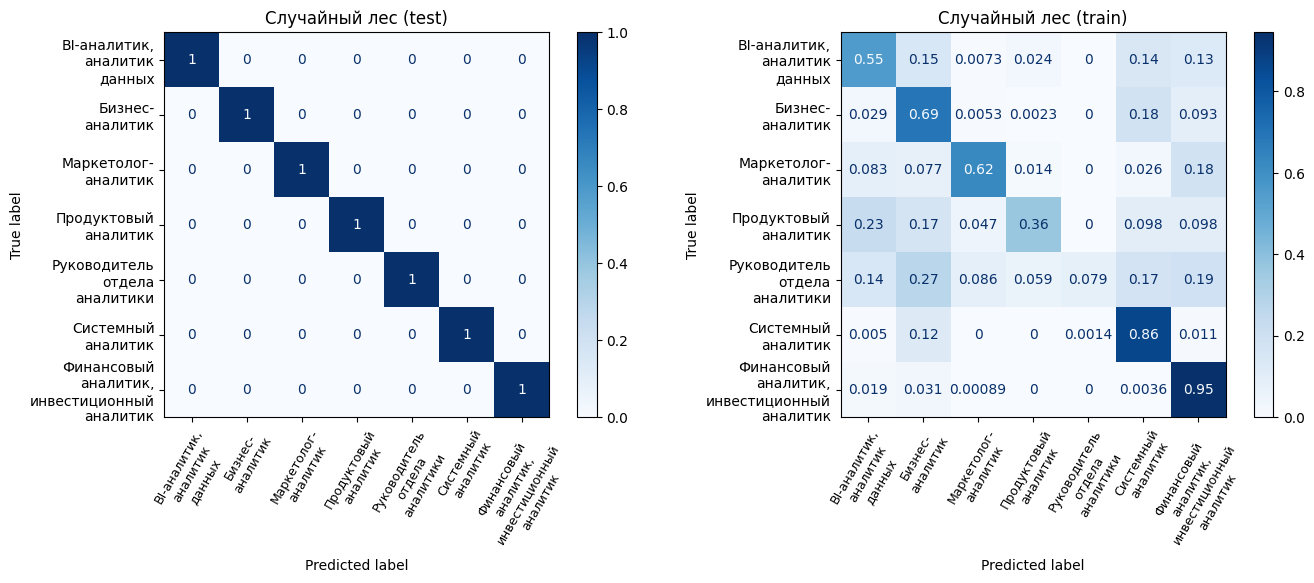

In [321]:
estimation(randForest_tfidf, X_test, X_train, y_test, y_train, 'Случайный лес')

SVM prediction

In [239]:
df_test = df_full[['id', 'clean_descr', 'proffesional_roles']].copy()

In [240]:
df_test['predicted'] = np.nan

In [241]:
df_test['predicted'][df_test['predicted'].isna() == True] = svm.predict(df_test['clean_descr'][df_test['predicted'].isna() == True])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18412\1411393600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted'][df_test['predicted'].isna() == True] = svm.predict(df_test['clean_descr'][df_test['predicted'].isna() == True])


In [242]:
df_test['proffesional_roles'] = df_test['predicted']

In [243]:
df_test.drop(['predicted'], axis = 1, inplace = True)

In [244]:
df_test

,id,clean_descr,proffesional_roles
3639,73346224,garnet инвестиционный компания сфера недвижимо...,"Финансовый аналитик, инвестиционный аналитик"
3640,73346307,ждать анализ дать производственный процесс под...,Бизнес-аналитик
3641,73346980,обязанность участие внедрение дальнейший разви...,Бизнес-аналитик
3642,73346981,обязанность участие внедрение дальнейший разви...,Бизнес-аналитик
3643,73346982,обязанность участие внедрение дальнейший разви...,Бизнес-аналитик
...,...,...,...
87787,77578538,проект канал устройство самообслуживание созда...,Системный аналитик
88178,78796215,a evolve рекламный агентство сфера digital наш...,Маркетолог-аналитик
86084,78722840,ао центр инвест девелопер московский рынок нед...,Маркетолог-аналитик
86107,78725974,компания like центр открыть позиция продуктовы...,Продуктовый аналитик
